In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


In [ ]:
'''
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

measurement_summary_df = pd.read_csv("Measurement_summary.csv")

station_code = 101  # Replace with your desired station code
filtered_df = measurement_summary_df[measurement_summary_df["Station code"] == station_code]

# Drop unnecessary columns
filtered_df.drop(columns=["Station code", "Address", "Latitude", "Longitude"], inplace=True)

# Select pollutant measurements for scaling
pollutant_measurement = filtered_df[["SO2", "NO2", "O3", "CO", "PM10", "PM2.5"]]

# Scale the pollutant data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_pollutant = scaler.fit_transform(pollutant_measurement)

# Replace original columns with scaled values (optional)
scaled_df = pd.DataFrame(scaled_pollutant, columns=["SO2", "NO2", "O3", "CO", "PM10", "PM2.5"])
filtered_df.update(scaled_df)

# Verify the result
print(filtered_df.head())
'''

       Measurement date       SO2       NO2        O3        CO      PM10  \
0      2017-01-01 00:00  0.714083  0.954914  0.756226  0.053659  0.143133   
1      2017-01-01 01:00  0.714083  0.954013  0.756226  0.053659  0.139265   
2      2017-01-01 02:00  0.714083  0.952209  0.756226  0.053659  0.137331   
3      2017-01-01 03:00  0.714083  0.952209  0.756226  0.053659  0.137331   
4      2017-01-01 04:00  0.713371  0.947701  0.756226  0.053659  0.135397   
...                 ...       ...       ...       ...       ...       ...   
25900  2019-12-31 19:00  0.713371  0.925158  0.765283  0.036585  0.052224   
25901  2019-12-31 20:00  0.713371  0.923354  0.765283  0.034146  0.054159   
25902  2019-12-31 21:00  0.713371  0.914337  0.770566  0.034146  0.046422   
25903  2019-12-31 22:00  0.713371  0.921551  0.765283  0.036585  0.040619   
25904  2019-12-31 23:00  0.714083  0.933273  0.758491  0.036585  0.040619   

          PM2.5  
0      0.112840  
1      0.116732  
2      0.116732  
3  

C:\Users\tranx\AppData\Local\Temp\ipykernel_19940\1262947257.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(columns=["Station code", "Address", "Latitude", "Longitude"], inplace=True)


In [ ]:
# Load data and convert the 'Measurement date' column
df = pd.read_csv("Measurement_summary.csv")
df['Measurement date'] = pd.to_datetime(df['Measurement date'])

# Replace invalid values with NaN and drop missing values
df.replace(-1, pd.NA, inplace=True)
df.dropna(inplace=True)

# Define a function to remove outliers using IQR
def remove_outliers_iqr(df, columns, factor=1.5):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        
        # Remove outliers based on the IQR bounds
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Columns for outlier removal
pollutant_columns = ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']

# Apply the outlier removal function
df_clean = remove_outliers_iqr(df, pollutant_columns)

# Group by 'Measurement date' (hourly) and calculate the mean for each pollutant
hourly_avg_df = df_clean.groupby('Measurement date').agg({
    'SO2': 'mean',
    'NO2': 'mean',
    'O3': 'mean',
    'CO': 'mean',
    'PM10': 'mean',
    'PM2.5': 'mean'
}).reset_index()

hourly_avg_df.replace(0, pd.NA, inplace=True)
hourly_avg_df.dropna(inplace=True)

pollutant_measurement = hourly_avg_df[["SO2", "NO2", "O3", "CO", "PM10", "PM2.5"]]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_pollutant = scaler.fit_transform(pollutant_measurement)
# Verify the resulting DataFrame



NameError: name 'pd' is not defined

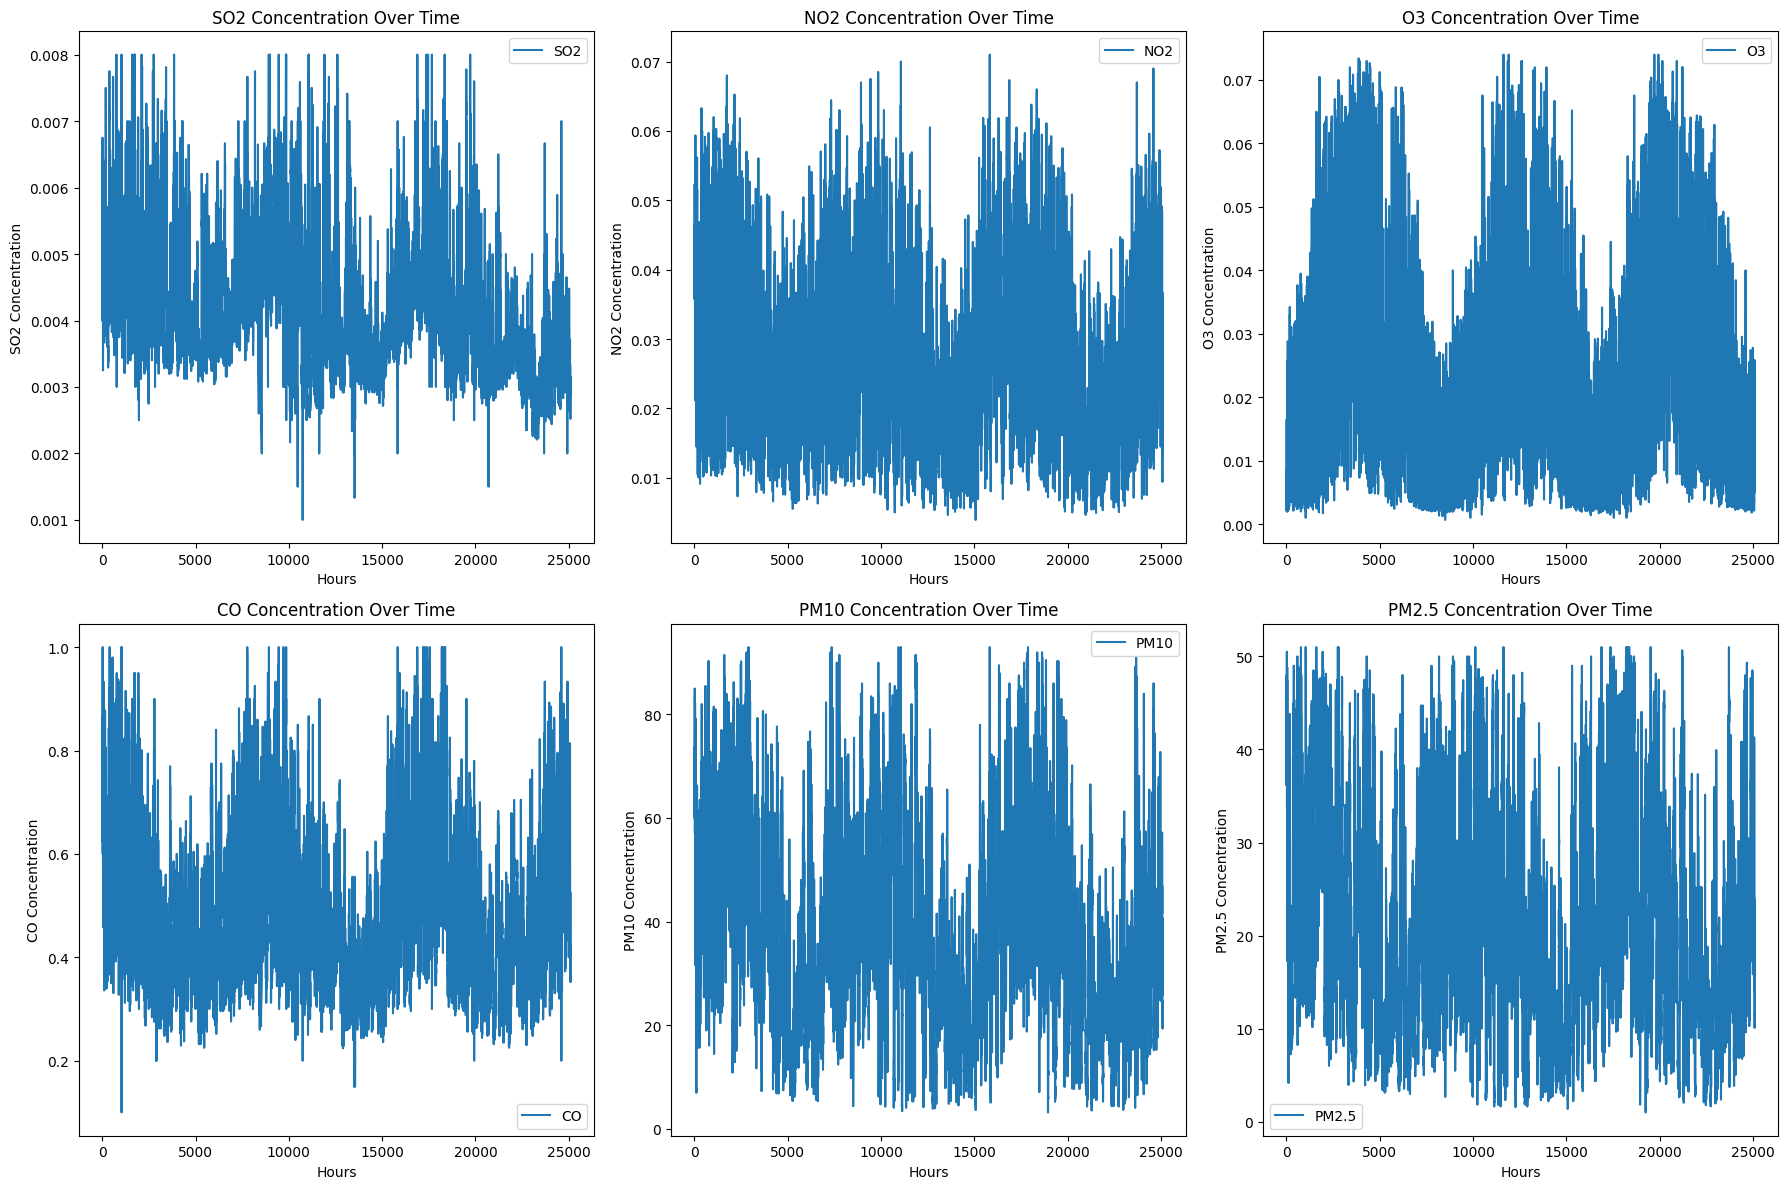

In [100]:
import matplotlib.pyplot as plt

# Assuming `hourly_avg_df` is your DataFrame with pollutant data

# List of pollutants
pollutants = ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']

# Set up a 2x3 grid for plotting
plt.figure(figsize=(18, 12))

# Create a plot for each pollutant
for i, pollutant in enumerate(pollutants):
    plt.subplot(2, 3, i+1)  # Create a 2x3 grid of subplots (6 graphs)
    plt.plot(hourly_avg_df[pollutant], label=f'{pollutant}')
    plt.title(f'{pollutant} Concentration Over Time')
    plt.xlabel('Hours')
    plt.ylabel(f'{pollutant} Concentration')
    plt.legend()

# Adjust layout for better spacing between the plots
plt.tight_layout()
plt.show()


In [90]:
# So what I do in the model here:
# I am using the value of the day before to predict the hour of the next day
# Example: 11/30/2024 -> 24 hours 12:00AM -> 12:00PM 
# 1 1.01 1.02 1.03 ... 0.98
# 12/1/2024 -> 12:00AM today? -> Basically I used the data of previous 24 hours to predict the next hour

def create_sequences(data, time_steps):
    sequences = []
    labels = []
    for i in range(0, len(data) - time_steps):
        sequences.append(data[i:i+time_steps])
        labels.append(data[i+time_steps])
    return np.array(sequences), np.array(labels)

X, y = create_sequences(scaled_pollutant, 24)

train_size = int(X.shape[0] * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

y_test_original = scaler.inverse_transform(y_test)
print(y_test_original)

[[3.640e-03 2.140e-02 4.848e-02 4.360e-01 4.484e+01 3.260e+01]
 [3.760e-03 1.876e-02 5.540e-02 4.080e-01 4.736e+01 3.448e+01]
 [3.920e-03 1.576e-02 6.252e-02 3.880e-01 4.704e+01 3.396e+01]
 ...
 [2.960e-03 2.492e-02 1.392e-02 4.640e-01 2.280e+01 1.424e+01]
 [3.000e-03 3.188e-02 8.440e-03 5.000e-01 2.304e+01 1.560e+01]
 [3.000e-03 3.660e-02 5.040e-03 5.240e-01 2.208e+01 1.456e+01]]


In [71]:
from tensorflow.keras import regularizers
model = Sequential()

model.add(SimpleRNN(units=50, return_sequences=False, input_shape=(24, 6), kernel_regularizer=regularizers.l2(0.01)))


model.add(Dense(units=6))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

# Train the RNN model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

model.save('full_model.keras')

C:\Users\tranx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         2,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,156 (12.33 KB)

 Trainable params: 3,156 (12.33 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1007 - val_loss: 0.0112
Epoch 2/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0109 - val_loss: 0.0064
Epoch 3/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0075 - val_loss: 0.0059
Epoch 4/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0069 - val_loss: 0.0051
Epoch 5/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0064 - val_loss: 0.0047
Epoch 6/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0060 - val_loss: 0.0045
Epoch 7/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 8/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0055 - val_loss: 0.0040
Epoch 9/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0053 - val_loss: 0.0039
Epoch 10/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0050 - val_loss: 0.0037
Epoch 11/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 12/100
623/623 ━━━━━━━━━━━━━━━━━━━

In [88]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Reconstruct the model manually (without batch_input_shape and time_major)
model = Sequential()
model.add(SimpleRNN(units=50, input_shape=(24, 6)))  # Rebuild the RNN layer without batch_input_shape
model.add(Dense(6))  # Add the output layer or other layers as per your architecture

# Load the weights into the model
model.load_weights('full_model.keras')


C:\Users\tranx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [89]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model
from tensorflow.keras import initializers
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
y_pred = model.predict(X_test)
r2_scores = []

for i in range(y_pred.shape[1]):
    r2 = r2_score(y_test[:, i], y_pred[:, i])  # R² for each feature
    r2_scores.append(r2)

print("R² scores for each feature:", r2_scores)

y_pred_original = scaler.inverse_transform(y_pred)
print(y_pred_original)

mae_scores = []
rmse_scores = []
mape_scores = []

# Calculate errors for each feature
for i in range(y_pred.shape[1]):
    mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_test[:, i], y_pred[:, i]))
    mape = mean_absolute_percentage_error(y_test[:, i], y_pred[:, i])
    
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    mape_scores.append(mape)

# Print results
print("Mean Absolute Error (MAE) for each feature:", mae_scores)
print("Root Mean Squared Error (RMSE) for each feature:", rmse_scores)
print("Mean Absolute Percentage Error (MAPE) for each feature:", mape_scores)

156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
R² scores for each feature: [0.7893317462855853, 0.9458446579932669, 0.9546780941976564, 0.9282464996673031, 0.9410552807466243, 0.964201076668611]
[[3.6628454e-03 1.9322954e-02 4.5969538e-02 3.8150558e-01 3.9866165e+01
  2.9404202e+01]
 [3.6816427e-03 2.0233681e-02 4.9741115e-02 4.0085799e-01 4.3954941e+01
  3.2116974e+01]
 [3.7507550e-03 1.6567107e-02 5.7588667e-02 3.7508827e-01 4.6533112e+01
  3.3712276e+01]
 ...
 [3.2000637e-03 2.3477742e-02 1.5384589e-02 4.2955214e-01 2.3296244e+01
  1.5002632e+01]
 [3.1254916e-03 2.4742182e-02 1.3105092e-02 4.4591984e-01 2.1093960e+01
  1.3965766e+01]
 [3.1384688e-03 3.3305317e-02 5.9226388e-03 5.0573236e-01 2.1968903e+01
  1.5391324e+01]]
Mean Absolute Error (MAE) for each feature: [0.024491358713401728, 0.02715038019208579, 0.03329856218916015, 0.029928827897458047, 0.02506516549182408, 0.024407820370074315]
Root Mean Squared Error (RMSE) for each feature: [0.03482928196739192, 0.039766974552711956, 0.04

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


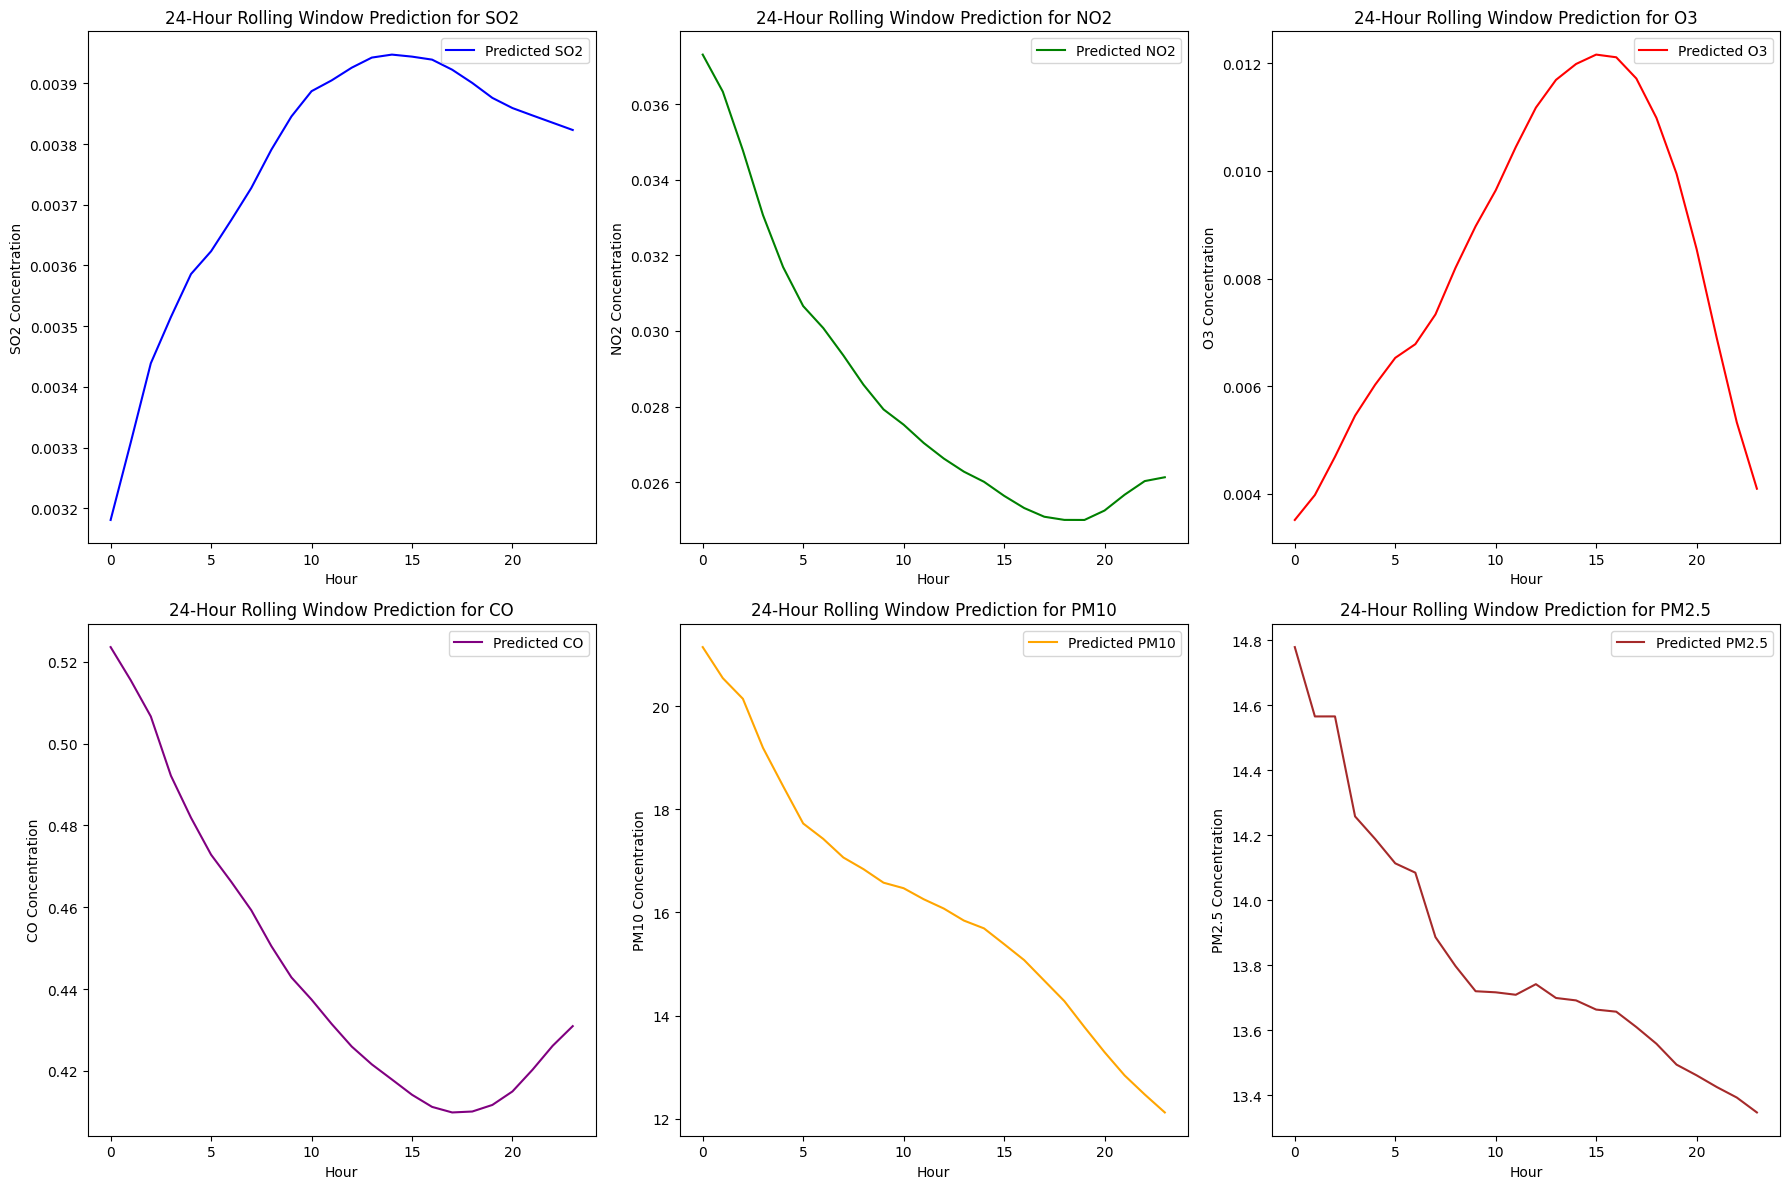

Predicted values for the next 24 hours (scaled):
[[0.31153885 0.49780726 0.03887689 0.47062278 0.20057459 0.2755852 ]
 [0.3297568  0.4831998  0.04519483 0.46163172 0.19387542 0.27131638]
 [0.34841147 0.46002287 0.05488247 0.45179224 0.18941727 0.27131855]
 [0.3592884  0.43450353 0.06528838 0.43570787 0.17883345 0.26516172]
 [0.36941653 0.41402668 0.07314175 0.42429376 0.17056999 0.26377252]
 [0.37478292 0.3986236  0.0799409  0.41425472 0.16250253 0.26227263]
 [0.38209724 0.38995302 0.08341086 0.40692425 0.15917723 0.26169765]
 [0.38966164 0.37916487 0.09093133 0.39918166 0.15515842 0.2577326 ]
 [0.39868212 0.36761528 0.1027588  0.38943428 0.15264761 0.25594556]
 [0.4065135  0.35786176 0.11327742 0.38092834 0.14971945 0.25439963]
 [0.4124551  0.3518461  0.122379   0.3749167  0.14852831 0.25433263]
 [0.41499555 0.3446288  0.1333448  0.36830842 0.14614542 0.25418174]
 [0.41798693 0.33848026 0.1433252  0.36216494 0.14413734 0.25483418]
 [0.4203642  0.3333108  0.15035623 0.35732344 0.141541

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Assuming `model` is your trained model and `scaled_pollutant` is the data you want to predict on

# Create the rolling window prediction function
def rolling_window_forecast(model, data, window_size, forecast_steps):
    predictions = []
    input_sequence = data[-window_size:]  # Start with the most recent 24 hours of data
    
    for step in range(forecast_steps):
        # Predict the next time step
        predicted = model.predict(input_sequence.reshape(1, window_size, input_sequence.shape[1]))
        
        # Append the predicted value to the input sequence and remove the oldest value
        predictions.append(predicted[0])  # Append the predicted value (flattened)
        
        # Update the input sequence: remove the first hour and add the predicted value
        input_sequence = np.append(input_sequence[1:], predicted, axis=0)
    
    return np.array(predictions)

# Example usage:
# Use the last 24 hours from the data
window_size = 24
forecast_steps = 24  # We want to predict 24 hours ahead

# Perform the rolling window forecast
predictions = rolling_window_forecast(model, scaled_pollutant, window_size, forecast_steps)

# Invert the scaling to get actual values (e.g., pollutant concentrations)
predicted_values = scaler.inverse_transform(predictions)

# Create separate plots for each pollutant
pollutants = ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

plt.figure(figsize=(18, 12))

for i, pollutant in enumerate(pollutants):
    plt.subplot(2, 3, i+1)  # Create a 2x3 grid of subplots
    plt.plot(np.arange(forecast_steps), predicted_values[:, i], label=f'Predicted {pollutant}', color=colors[i])
    plt.xlabel('Hour')
    plt.ylabel(f'{pollutant} Concentration')
    plt.title(f'24-Hour Rolling Window Prediction for {pollutant}')
    plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# If you want to print or return predictions for all pollutants
print("Predicted values for the next 24 hours (scaled):")
print(predictions)
